# Risk Deep Dive: Geographic & Temporal Analysis
   
   Detailed risk analysis for AXA Deutschland bike-share insurance pricing.
   
   **Prerequisites**: Run `make scorecard MODE=nyc` first.
   
   **Audience**: Technical teams, actuaries, data scientists

## How to run (recommended)

From the repo root:

```bash
make all MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
make report MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
```

The Makefile sets environment variables (e.g. `CITIBIKE_PARQUET_DIR`, `CITIBIKE_YEARS`, `CITIBIKE_MONTHS`) which this notebook reads.


## Analysis Overview
   
   This notebook provides detailed risk analysis including:
   1. **High-Risk Station Identification** - Top 10% riskiest stations
   2. **Geographic Clustering** - Do high-risk stations cluster?
   3. **Risk Distribution** - How is risk distributed across the system?
   4. **Temporal Patterns** - When is exposure highest?
   5. **Executive Summary** - AXA-ready metrics
   
   **Run time**: ~2 minutes

In [1]:
# --- Setup (STRICT): locate repo, resolve RUN_DIR + PARQUET_DIR, load summaries safely ---
from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

try:
    from IPython.display import display, Markdown
    _HAVE_IPYTHON = True
except Exception:
    display = print
    Markdown = lambda x: x
    _HAVE_IPYTHON = False

# Ensure figures render into the executed notebook outputs
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

plt.ioff()  # nbconvert-friendly (prevents interactive windows)

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "Makefile").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
SUMMARIES_ROOT = REPO_ROOT / "summaries"

def _parse_int_list(val: str | None):
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    parts = re.split(r"[,\s]+", s)
    out = []
    for p in parts:
        if not p:
            continue
        try:
            out.append(int(p))
        except Exception:
            pass
    return out or None

# Inputs from Makefile (recommended)
PARQUET_DIR_ENV = (os.environ.get("CITIBIKE_PARQUET_DIR") or "").strip()
RUN_DIR_ENV     = (os.environ.get("CITIBIKE_RUN_DIR") or "").strip()
MODE_ENV        = (os.environ.get("CITIBIKE_MODE") or os.environ.get("MODE") or "").strip().lower()

YEARS_FILTER  = _parse_int_list(os.environ.get("CITIBIKE_YEARS")  or os.environ.get("YEARS"))
MONTHS_FILTER = _parse_int_list(os.environ.get("CITIBIKE_MONTHS") or os.environ.get("MONTHS"))

PARQUET_DIR = Path(PARQUET_DIR_ENV) if PARQUET_DIR_ENV else Path()
if RUN_DIR_ENV:
    RUN_DIR = Path(RUN_DIR_ENV)
else:
    # Infer RUN_TAG from parquet folder name; expects .../citibike_parquet/<RUN_TAG>
    run_tag = PARQUET_DIR.name if str(PARQUET_DIR).strip() else ""
    RUN_DIR = SUMMARIES_ROOT / run_tag if run_tag else Path()

# Resolve relative -> absolute (relative to REPO_ROOT)
if RUN_DIR and (not RUN_DIR.is_absolute()):
    RUN_DIR = (REPO_ROOT / RUN_DIR).resolve()
if PARQUET_DIR and (not PARQUET_DIR.is_absolute()):
    PARQUET_DIR = (REPO_ROOT / PARQUET_DIR).resolve()

# ---- STRICT checks ----
if not (REPO_ROOT / "Makefile").exists():
    raise FileNotFoundError(
        f"Expected to find repo root (Makefile) by walking up from CWD.\n"
        f"  CWD: {Path.cwd().resolve()}\n"
        f"  Derived REPO_ROOT: {REPO_ROOT}"
    )

if not SUMMARIES_ROOT.exists():
    raise FileNotFoundError(
        f"Expected summaries/ folder not found at: {SUMMARIES_ROOT}\n"
        "Run: make summarize (or make all) first."
    )

if not RUN_DIR.exists():
    raise FileNotFoundError(
        f"Expected summaries run_dir not found:\n  {RUN_DIR}\n"
        "Run: make summarize (or make all) first."
    )

if not PARQUET_DIR.exists():
    raise FileNotFoundError(
        f"Expected parquet dir not found:\n  {PARQUET_DIR}\n"
        "Run: make ingest (or make all) first."
    )

REQUIRED_RUN_FILES = [
    "citibike_trips_by_year.csv",
    "citibike_trips_by_month.csv",
    "citibike_trips_by_dow.csv",
    "citibike_trips_by_hour.csv",
]
missing = [f for f in REQUIRED_RUN_FILES if not (RUN_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        "Missing required summary CSVs in run_dir:\n"
        f"  {RUN_DIR}\n"
        f"Missing: {missing}\n"
        "Run: make summarize (or make all) first."
    )

print("REPO_ROOT:", REPO_ROOT)
print("PARQUET_DIR:", PARQUET_DIR)
print("RUN_DIR:", RUN_DIR)
print("MODE (env):", MODE_ENV or "(not set)")
print("YEARS_FILTER:", YEARS_FILTER, "MONTHS_FILTER:", MONTHS_FILTER)

# Where to save figures (also show inline)
FIG_DIR = REPO_ROOT / "reports" / RUN_DIR.name / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR)

def savefig(filename: str):
    out = FIG_DIR / filename
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

def read_csv(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

# ---- Load per-run summary CSVs ----
df_year  = read_csv(RUN_DIR / "citibike_trips_by_year.csv")
df_month = read_csv(RUN_DIR / "citibike_trips_by_month.csv")
df_dow   = read_csv(RUN_DIR / "citibike_trips_by_dow.csv")
df_hour  = read_csv(RUN_DIR / "citibike_trips_by_hour.csv")

# Optional per-run outputs
station_path = RUN_DIR / "citibike_station_exposure.csv"
df_station = read_csv(station_path) if station_path.exists() else None

risk_path = RUN_DIR / "station_risk_exposure_plus_crashproximity.csv"
df_risk = read_csv(risk_path) if risk_path.exists() else None

highlights_path = RUN_DIR / "summary_highlights.md"

# Mode detection (prefer data, else env)
mode = (
    str(df_year["mode"].iloc[0]).lower()
    if ("mode" in df_year.columns and len(df_year))
    else (MODE_ENV or "unknown")
)
print("Detected mode:", mode)

# ---- Compare tables (optional) ----
# If YEARS/MONTHS filters are passed (e.g., Jan–Mar), we default to THIS run only.
USE_COMPARE = (YEARS_FILTER is None and MONTHS_FILTER is None)
COMPARE_DIR = SUMMARIES_ROOT / "_compare"

def _maybe_load_compare(fname: str) -> pd.DataFrame | None:
    p = COMPARE_DIR / fname
    return read_csv(p) if p.exists() else None

if USE_COMPARE and COMPARE_DIR.exists():
    _y = _maybe_load_compare("citibike_trips_by_year_ALL.csv")
    _m = _maybe_load_compare("citibike_trips_by_month_ALL.csv")
    _d = _maybe_load_compare("citibike_trips_by_dow_ALL.csv")
    _h = _maybe_load_compare("citibike_trips_by_hour_ALL.csv")
    df_year_all  = _y if _y is not None else df_year.copy()
    df_month_all = _m if _m is not None else df_month.copy()
    df_dow_all   = _d if _d is not None else df_dow.copy()
    df_hour_all  = _h if _h is not None else df_hour.copy() 
else:
    df_year_all, df_month_all, df_dow_all, df_hour_all = df_year.copy(), df_month.copy(), df_dow.copy(), df_hour.copy()

# Always filter _ALL tables to current mode (if they have a mode column)
for _name in ["df_year_all", "df_month_all", "df_dow_all", "df_hour_all"]:
    _df = locals()[_name]
    if isinstance(_df, pd.DataFrame) and ("mode" in _df.columns):
        locals()[_name] = _df[_df["mode"].astype(str).str.lower() == mode].copy()

# If filters are provided, enforce them on the per-run tables too (defensive)
def _filter_year_month(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if YEARS_FILTER is not None and "year" in out.columns:
        out["year"] = pd.to_numeric(out["year"], errors="coerce")
        out = out[out["year"].isin(YEARS_FILTER)]
    if MONTHS_FILTER is not None and "month" in out.columns:
        out["month"] = pd.to_numeric(out["month"], errors="coerce")
        out = out[out["month"].isin(MONTHS_FILTER)]
    return out

df_year  = _filter_year_month(df_year)
df_month = _filter_year_month(df_month)
df_dow   = _filter_year_month(df_dow)
df_hour  = _filter_year_month(df_hour)

# Helpful run label for titles
run_label = RUN_DIR.name


REPO_ROOT: /home/maral/Desktop/citibike-insurance-challenge
PARQUET_DIR: /home/maral/Desktop/citibike-insurance-challenge/data/processed/citibike_parquet/y2018_2020_m1_2_3_modejc
RUN_DIR: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2018_2020_m1_2_3_modejc
MODE (env): jc
YEARS_FILTER: [2018, 2020] MONTHS_FILTER: [1, 2, 3]
FIG_DIR: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures
Detected mode: jc


## 8) Risk Deep Dive Analysis

Now that we have the AXA scorecard, let's analyze:
- **WHERE**: Which stations are highest risk? Do they cluster geographically?
- **WHEN**: Does risk vary by hour of day or day of week?
- **WHO**: What exposure levels do high-risk stations have?

This analysis helps AXA:
1. **Price accurately**: Understand risk distribution
2. **Target prevention**: Find geographic clusters for safety campaigns
3. **Optimize products**: Match offerings to temporal patterns

In [2]:
# ============================================================================
# LOAD SCORECARD DATA
# ============================================================================

print("\n" + "="*70)
print("RISK DEEP DIVE ANALYSIS")
print("="*70)

# Load scorecard (if exists)
scorecard_path = RUN_DIR / "axa_partner_scorecard_500m.csv"

if scorecard_path.exists():
    df_score = pd.read_csv(scorecard_path)
    print(f"✅ Loaded scorecard: {len(df_score):,} stations")
    
    # Check for credibility column
    has_credibility = 'credibility_flag' in df_score.columns
    if not has_credibility:
        # Add credibility flag based on exposure if missing
        df_score['credibility_flag'] = df_score['exposure_trips'].apply(
            lambda x: 'credible' if x >= 5000 else 'insufficient_data'
        )
        print("⚠️  Added credibility_flag column (≥5000 trips = credible)")
    
    print(f"\nCredibility breakdown:")
    print(df_score['credibility_flag'].value_counts())
    
    # Show sample
    print(f"\nSample scorecard data:")
    display(df_score.head())
else:
    print("⚠️  Scorecard not found. Run: make scorecard MODE=" + mode)
    df_score = None


RISK DEEP DIVE ANALYSIS
✅ Loaded scorecard: 74 stations

Credibility breakdown:
credibility_flag
no_risk_data    74
Name: count, dtype: int64

Sample scorecard data:


,mode,start_station_id,start_station_name,station_lat,station_lng,exposure_trips,crash_count,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,...,risk_pct,axa_priority_score,prevention_hotspot,product_hotspot,acquisition_hotspot,exposure_index_pct,eb_risk_rate_per_100k_trips,risk_index_pct,expected_incidents_proxy,scoring_strategy
0,jc,3186,Grove St PATH,40.719586,-74.043117,27901,0,0.0,0.0,13.221316,...,0.0,1.000000,True,True,True,100.000000,NaN,NaN,NaN,exposure_only_no_risk_signal
1,jc,3203,Hamilton Park,40.727596,-74.044247,12387,0,0.0,0.0,29.780249,...,0.0,0.986486,True,True,True,98.648649,NaN,NaN,NaN,exposure_only_no_risk_signal
2,jc,3195,Sip Ave,40.730820,-74.063848,12119,0,0.0,0.0,30.438811,...,0.0,0.972973,True,True,True,97.297297,NaN,NaN,NaN,exposure_only_no_risk_signal
3,jc,3202,Newport PATH,40.727224,-74.033759,9224,0,0.0,0.0,39.992188,...,0.0,0.959459,True,True,True,95.945946,NaN,NaN,NaN,exposure_only_no_risk_signal
4,jc,3639,Harborside,40.719252,-74.034234,8201,0,0.0,0.0,44.980849,...,0.0,0.945946,True,True,True,94.594595,NaN,NaN,NaN,exposure_only_no_risk_signal


### 8.1 High-Risk Stations: WHO and WHERE

In [3]:
# --- HIGH-RISK STATIONS ---
if df_score is not None:
    print("\n" + "="*70)
    print("HIGH-RISK STATIONS ANALYSIS")
    print("="*70)
    
    # Filter to credible high-risk stations (top 10% risk)
    credible_stations = df_score[df_score['credibility_flag'] == 'credible'].copy()
    
    if len(credible_stations) > 0 and 'risk_index_pct' in credible_stations.columns:
        high_risk = credible_stations[credible_stations['risk_index_pct'] >= 90].copy()
        
        print(f"\nHigh-risk stations (≥90th percentile): {len(high_risk):,}")
        print(f"Total exposure at high-risk stations: {high_risk['exposure_trips'].sum():,} trips")
        
        # Top 10 highest risk
        top_risk = high_risk.nlargest(10, 'eb_risk_rate_per_100k_trips')[[
            'start_station_id', 'start_station_name', 'station_lat', 'station_lng',
            'exposure_trips', 'crash_count', 'eb_risk_rate_per_100k_trips', 'risk_index_pct'
        ]].copy()
        
        print("\n📍 Top 10 Highest-Risk Stations:")
        display(top_risk)
        
        # Geographic clustering analysis
        if len(high_risk) > 1:
            try:
                from sklearn.cluster import DBSCAN
                import numpy as np
                
                # Cluster high-risk stations geographically
                coords = high_risk[['station_lat', 'station_lng']].values
                
                # DBSCAN clustering (0.01 degrees ≈ 1km)
                clustering = DBSCAN(eps=0.01, min_samples=2).fit(coords)
                high_risk['cluster'] = clustering.labels_
                
                # Count clusters
                n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
                n_noise = list(clustering.labels_).count(-1)
                
                print(f"\n🗺️  Geographic Clustering:")
                print(f"  High-risk clusters identified: {n_clusters}")
                print(f"  Isolated high-risk stations: {n_noise}")
                
                # Show cluster details
                if n_clusters > 0:
                    cluster_summary = high_risk[high_risk['cluster'] >= 0].groupby('cluster').agg({
                        'start_station_id': 'count',
                        'exposure_trips': 'sum',
                        'crash_count': 'sum',
                        'station_lat': 'mean',
                        'station_lng': 'mean'
                    }).rename(columns={'start_station_id': 'stations_in_cluster'})
                    
                    print("\nCluster Details:")
                    display(cluster_summary)
            except ImportError:
                print("⚠️  sklearn not installed - skipping geographic clustering")
                print("   Install with: pip install scikit-learn")
    else:
        print("⚠️  No credible stations with risk data available")


HIGH-RISK STATIONS ANALYSIS
⚠️  No credible stations with risk data available


### 8.2 Risk Distribution Overview

In [4]:
# --- RISK DISTRIBUTION ---
if df_score is not None and len(credible_stations) > 0:
    print("\n" + "="*70)
    print("RISK DISTRIBUTION ANALYSIS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Risk Histogram
    ax = axes[0, 0]
    ax.hist(credible_stations['eb_risk_rate_per_100k_trips'].dropna(), 
            bins=30, edgecolor='black', alpha=0.7, color='#2E86AB')
    ax.axvline(credible_stations['eb_risk_rate_per_100k_trips'].median(), 
               color='red', linestyle='--', label='Median', linewidth=2)
    ax.set_xlabel('EB Risk Rate (per 100k trips)', fontsize=11)
    ax.set_ylabel('Number of Stations', fontsize=11)
    ax.set_title('Risk Distribution (Credible Stations Only)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 2. Exposure vs Risk Scatter
    ax = axes[0, 1]
    scatter = ax.scatter(
        credible_stations['exposure_trips'], 
        credible_stations['eb_risk_rate_per_100k_trips'],
        c=credible_stations['crash_count'],
        cmap='YlOrRd',
        alpha=0.6,
        s=50
    )
    ax.set_xlabel('Exposure (trips)', fontsize=11)
    ax.set_ylabel('EB Risk Rate (per 100k trips)', fontsize=11)
    ax.set_title('Risk vs Exposure', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    plt.colorbar(scatter, ax=ax, label='Crash Count')
    ax.grid(alpha=0.3)
    
    # Mark prevention hotspots
    if 'prevention_hotspot' in credible_stations.columns:
        hotspots = credible_stations[credible_stations['prevention_hotspot'] == True]
        if len(hotspots) > 0:
            ax.scatter(hotspots['exposure_trips'], 
                      hotspots['eb_risk_rate_per_100k_trips'],
                      color='red', s=200, marker='*', 
                      edgecolors='black', linewidths=1,
                      label='Prevention Hotspots', zorder=5)
            ax.legend()
    
    # 3. Risk Tiers
    ax = axes[1, 0]
    if 'risk_index_pct' in credible_stations.columns:
        # Create risk tiers
        credible_stations['risk_tier'] = pd.cut(
            credible_stations['risk_index_pct'],
            bins=[0, 33, 66, 100],
            labels=['Low Risk', 'Medium Risk', 'High Risk']
        )
        
        tier_counts = credible_stations['risk_tier'].value_counts()
        colors = ['#4CAF50', '#FFC107', '#F44336']
        tier_counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
        ax.set_xlabel('Risk Tier', fontsize=11)
        ax.set_ylabel('Number of Stations', fontsize=11)
        ax.set_title('Station Distribution by Risk Tier', fontsize=12, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.grid(alpha=0.3, axis='y')
        
        # Add percentages on bars
        for i, v in enumerate(tier_counts):
            pct = v / len(credible_stations) * 100
            ax.text(i, v, f'{v}\n({pct:.1f}%)', 
                   ha='center', va='bottom', fontweight='bold')
    
    # 4. Expected Incidents Distribution
    ax = axes[1, 1]
    if 'expected_incidents_proxy' in credible_stations.columns:
        top_20 = credible_stations.nlargest(20, 'expected_incidents_proxy')
        ax.barh(range(len(top_20)), top_20['expected_incidents_proxy'], 
                color='#E74C3C', edgecolor='black')
        ax.set_yticks(range(len(top_20)))
        ax.set_yticklabels([f"{row['start_station_name'][:30]}..." 
                           if len(row['start_station_name']) > 30 
                           else row['start_station_name']
                           for _, row in top_20.iterrows()], fontsize=8)
        ax.set_xlabel('Expected Incidents Proxy', fontsize=11)
        ax.set_title('Top 20 Stations by Expected Impact', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    savefig("08_risk_distribution_analysis.png")
    plt.show()

### 8.3 Temporal Risk Patterns: WHEN does risk peak?


TEMPORAL PATTERNS: HOUR OF DAY


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/09_trips_by_hour.png


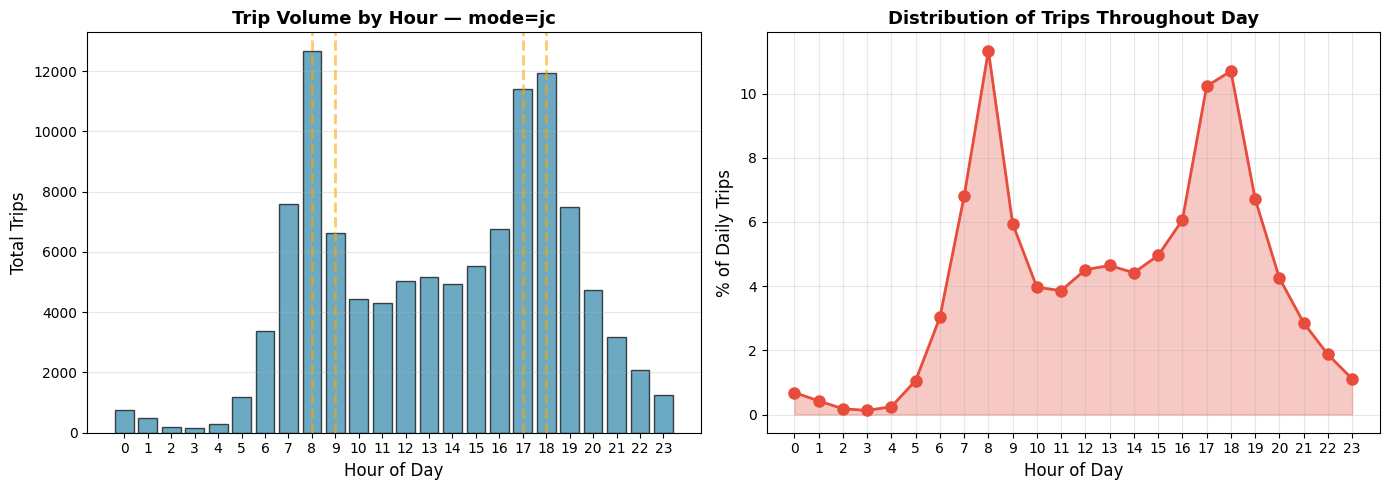


📊 Hour-of-Day Analysis:

Top 5 Busiest Hours:


,hour,trips,pct_of_daily
8,8,12654,11.339624
18,18,11940,10.699788
17,17,11414,10.228423
7,7,7598,6.808793
19,19,7498,6.719180


In [5]:
# --- TEMPORAL PATTERNS: HOUR OF DAY ---
if df_hour is not None:
    print("\n" + "="*70)
    print("TEMPORAL PATTERNS: HOUR OF DAY")
    print("="*70)
    
    # Hour data is already aggregated system-wide
    hour_summary = df_hour.groupby('hour')['trips'].sum().reset_index()
    hour_summary = hour_summary.sort_values('hour')
    
    # Calculate percentage of daily trips
    total_trips = hour_summary['trips'].sum()
    hour_summary['pct_of_daily'] = (hour_summary['trips'] / total_trips) * 100
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Trip volume by hour
    ax1.bar(hour_summary['hour'], hour_summary['trips'], 
           color='#2E86AB', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Hour of Day', fontsize=12)
    ax1.set_ylabel('Total Trips', fontsize=12)
    ax1.set_title(f'Trip Volume by Hour — mode={mode}', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(0, 24))
    ax1.grid(alpha=0.3, axis='y')
    
    # Mark rush hours
    rush_hours = [8, 9, 17, 18]
    for rh in rush_hours:
        ax1.axvline(rh, color='orange', linestyle='--', alpha=0.6, linewidth=2)
    
    # 2. Percentage distribution
    ax2.plot(hour_summary['hour'], hour_summary['pct_of_daily'], 
            marker='o', linewidth=2, markersize=8, color='#E74C3C')
    ax2.fill_between(hour_summary['hour'], hour_summary['pct_of_daily'], 
                     alpha=0.3, color='#E74C3C')
    ax2.set_xlabel('Hour of Day', fontsize=12)
    ax2.set_ylabel('% of Daily Trips', fontsize=12)
    ax2.set_title('Distribution of Trips Throughout Day', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(0, 24))
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    savefig("09_trips_by_hour.png")
    plt.show()
    
    print("\n📊 Hour-of-Day Analysis:")
    top_hours = hour_summary.nlargest(5, 'trips')[['hour', 'trips', 'pct_of_daily']]
    print("\nTop 5 Busiest Hours:")
    display(top_hours)


TEMPORAL PATTERNS: DAY OF WEEK


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2018_2020_m1_2_3_modejc/figures/10_trips_by_day_of_week.png


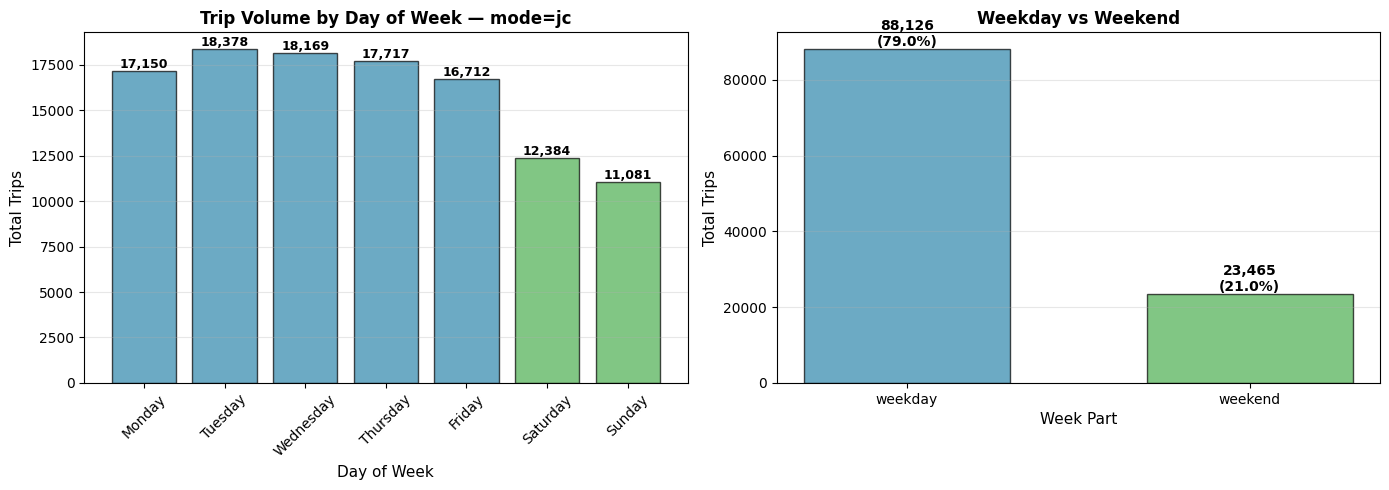


📊 Day-of-Week Analysis:


,dow_name,trips,pct_of_weekly
0,Monday,17150,15.368623
1,Tuesday,18378,16.469070
2,Wednesday,18169,16.281779
3,Thursday,17717,15.876728
4,Friday,16712,14.976118
5,Saturday,12384,11.097669
6,Sunday,11081,9.930012


In [6]:
# --- TEMPORAL PATTERNS: DAY OF WEEK ---
if df_dow is not None:
    print("\n" + "="*70)
    print("TEMPORAL PATTERNS: DAY OF WEEK")
    print("="*70)
    
    # Day-of-week data is already aggregated system-wide
    dow_summary = df_dow.groupby(['dow', 'dow_name']).agg({
        'trips': 'sum'
    }).reset_index()
    dow_summary = dow_summary.sort_values('dow')
    
    # Calculate percentage of weekly trips
    total_trips = dow_summary['trips'].sum()
    dow_summary['pct_of_weekly'] = (dow_summary['trips'] / total_trips) * 100
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Trip volume by day of week
    colors = ['#4CAF50' if 'Saturday' in str(x) or 'Sunday' in str(x) else '#2E86AB' 
              for x in dow_summary['dow_name']]
    
    ax1.bar(dow_summary['dow_name'], dow_summary['trips'], 
           color=colors, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Day of Week', fontsize=11)
    ax1.set_ylabel('Total Trips', fontsize=11)
    ax1.set_title(f'Trip Volume by Day of Week — mode={mode}', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(dow_summary.iterrows()):
        ax1.text(i, row['trips'], f"{row['trips']:,.0f}",
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2. Weekday vs Weekend comparison
    if 'week_part' in df_dow.columns:
        week_part_summary = df_dow.groupby('week_part').agg({
            'trips': 'sum'
        }).reset_index()
        
        week_part_summary['pct'] = (week_part_summary['trips'] / week_part_summary['trips'].sum()) * 100
        
        colors_wp = ['#2E86AB' if 'weekday' in str(x) else '#4CAF50' 
                     for x in week_part_summary['week_part']]
        
        ax2.bar(week_part_summary['week_part'], week_part_summary['trips'],
               color=colors_wp, edgecolor='black', width=0.6, alpha=0.7)
        ax2.set_xlabel('Week Part', fontsize=11)
        ax2.set_ylabel('Total Trips', fontsize=11)
        ax2.set_title('Weekday vs Weekend', fontsize=12, fontweight='bold')
        ax2.grid(alpha=0.3, axis='y')
        
        for i, (idx, row) in enumerate(week_part_summary.iterrows()):
            ax2.text(i, row['trips'], 
                    f"{row['trips']:,.0f}\n({row['pct']:.1f}%)",
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    savefig("10_trips_by_day_of_week.png")
    plt.show()
    
    print("\n📊 Day-of-Week Analysis:")
    display(dow_summary[['dow_name', 'trips', 'pct_of_weekly']])

### 8.4 Executive Risk Summary for AXA

In [7]:
# --- EXECUTIVE RISK SUMMARY ---
if df_score is not None:
    print("\n" + "="*70)
    print("EXECUTIVE RISK SUMMARY FOR AXA")
    print("="*70)
    
    # Create summary metrics
    summary_data = []
    
    # Overall metrics
    total_stations = len(df_score)
    credible_count = len(df_score[df_score['credibility_flag'] == 'credible'])
    
    summary_data.append({
        'Metric': 'Total Stations',
        'Value': f"{total_stations:,}",
        'Notes': f"{mode.upper()} mode"
    })
    
    summary_data.append({
        'Metric': 'Credible Stations (≥5K trips)',
        'Value': f"{credible_count:,} ({credible_count/total_stations*100:.1f}%)",
        'Notes': 'Suitable for risk-based pricing'
    })
    
    # Risk tiers
    if 'risk_tier' in credible_stations.columns:
        high_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'High Risk'])
        medium_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'Medium Risk'])
        low_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'Low Risk'])
        
        summary_data.append({
            'Metric': 'High Risk Stations',
            'Value': f"{high_risk_count:,} ({high_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Premium pricing tier'
        })
        
        summary_data.append({
            'Metric': 'Medium Risk Stations',
            'Value': f"{medium_risk_count:,} ({medium_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Standard pricing tier'
        })
        
        summary_data.append({
            'Metric': 'Low Risk Stations',
            'Value': f"{low_risk_count:,} ({low_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Discount pricing tier'
        })
    
    # Hotspots
    if 'prevention_hotspot' in df_score.columns:
        prevention_count = df_score['prevention_hotspot'].sum()
        summary_data.append({
            'Metric': 'Prevention Hotspots',
            'Value': f"{int(prevention_count):,}",
            'Notes': 'High exposure + High risk → Safety campaigns'
        })
    
    if 'product_hotspot' in df_score.columns:
        product_count = df_score['product_hotspot'].sum()
        summary_data.append({
            'Metric': 'Product Hotspots',
            'Value': f"{int(product_count):,}",
            'Notes': 'High exposure → Insurance sales opportunity'
        })
    
    if 'acquisition_hotspot' in df_score.columns:
        acquisition_count = df_score['acquisition_hotspot'].sum()
        summary_data.append({
            'Metric': 'Acquisition Hotspots',
            'Value': f"{int(acquisition_count):,}",
            'Notes': 'High exposure + Low risk → Easy wins'
        })
    
    # Display summary table
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)
    
    # Save to CSV
    summary_csv = RUN_DIR / "risk_executive_summary.csv"
    df_summary.to_csv(summary_csv, index=False)
    print(f"\n✅ Saved executive summary to: {summary_csv}")


EXECUTIVE RISK SUMMARY FOR AXA


,Metric,Value,Notes
0,Total Stations,74,JC mode
1,Credible Stations (≥5K trips),0 (0.0%),Suitable for risk-based pricing
2,Prevention Hotspots,8,High exposure + High risk → Safety campaigns
3,Product Hotspots,15,High exposure → Insurance sales opportunity
4,Acquisition Hotspots,23,High exposure + Low risk → Easy wins



✅ Saved executive summary to: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2018_2020_m1_2_3_modejc/risk_executive_summary.csv
